# **Music Generation using LSTM**

The aim of this project is to generate MIDI Files using a LSTM. The model generates notes by learning for a Music Database and converts these notes into a MIDI File.
The implementation is derived from the [Skuldur's Classical Piano Composer](https://github.com/Skuldur/Classical-Piano-Composer) using Python 3 and a dataset of Most Popular Hit Singles of the 21st Century.

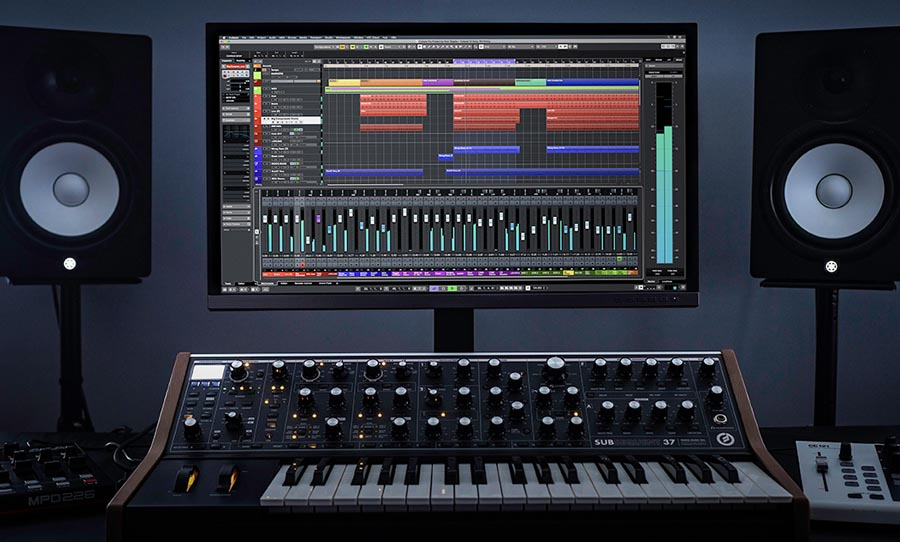

For this, some steps are needed:
1. Import the libraries and Load the model to be used.
2. Train the model.
3. Generate MIDI Files using the generated notes.

## **1. Installation**

In this part, the libraries will be imported and the model will be prepared for training:

*Note*: You can use the Model and Weights used in the [Classical Piano Composer Repository](https://github.com/Skuldur/Classical-Piano-Composer) as well as the Database used by cloning the Repository as follows:


In [ ]:
!git clone https://github.com/Skuldur/Classical-Piano-Composer.git

In our Case, we will use a similar Model and we will train it on a different Dataset. But first, we import the necessary libraries:

In [1]:
!sudo apt install -y fluidsynth &> /dev/null # Install fluidsynth as a MIDI synthesizer (1)
!pip install --upgrade pyfluidsynth &> /dev/null # &> /dev/null to redirect the output ( To hide it)
!pip install pretty_midi &> /dev/null # Intsall pretty_midi to better handle MIDI data

In [2]:
# Import the necessary libraries:
import glob
import pickle
import numpy as np
import collections
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream # For musical analysis (3)
import fluidsynth
import pretty_midi
from IPython import display

# Import the building blocks of the model:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

(1) For more information, check the [documentation](https://pypi.org/project/pyFluidSynth/)

(2) For more information, check the [documentation](https://pypi.org/project/pretty_midi/)

(3) For more information, check the [documentation](https://pypi.org/project/music21/)


After that, we will define the path of the MIDI Files directory, one file will be used for demonstration:

In [43]:
# Define Songs and Notes Directory:
songs = r"/content/songs/*.mid"
input_notes = r"/content/songs/notes"

# Choose one file and pass it to pretty_midi for better MIDI data handeling:
sample_file = glob.glob(str(pathlib.Path(songs)))[12]
print("The Test MIDI File:", sample_file)
file = pretty_midi.PrettyMIDI(sample_file)


The Test MIDI File: /content/songs/The Weeknd - Save Your Tearsa.mid


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Then, we will play the selected file with a specified duration and rate:

In [44]:
# Define the duration and rate:
duration = 30
rate = 16000

# Play the selected file:
waveform = file.fluidsynth(fs=rate)
waveform_short = waveform[:duration*rate]
display.Audio(waveform_short, rate=rate)

The Model used performs best using MIDI files with a single instrument, we can check the number of instruments used and their names:
 

In [65]:
print('Number of instruments:', len(file.instruments))
print('Instrument name:', pretty_midi.program_to_instrument_name(file.instruments[0].program))  

Number of instruments: 6
Instrument name: Alto Sax


In this case, we will be using MIDI files with multiple instruments, this will decrease the performance but it will allow the model to be more useful in numerous scenarios since the majority of MIDI files don't rely only on one Piano instrument.

To use the MIDI file efficiently, the data is arranged in a [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). This will make the process of fetching and parsing data faster and more organized:

In [46]:
# Convert MIDI data into DataFrame:
def midi_to_df(files: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(files)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time:
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  # Extract pitch, duration, step for each note:
  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [47]:
# Convert and display the first 10 notes:
music_df = midi_to_df(sample_file)
music_df.head(10)

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


pitch  start    end  step  duration
0     60   8.75   9.00  0.00      0.25
1     60   9.00   9.25  0.25      0.25
2     60   9.25   9.50  0.25      0.25
3     60   9.75  10.00  0.50      0.25
4     60  10.25  10.50  0.50      0.25
5     60  10.50  10.75  0.25      0.25
6     57  10.75  11.00  0.25      0.25
7     60  11.00  11.25  0.25      0.25
8     62  11.25  11.50  0.25      0.25
9     59  11.50  12.00  0.25      0.50

The goal of the previous code is to convert the data stored the MIDI file from a structure that we're familiar with (Image below) to a structure that a computer can understand. 

The process is to convert each note (Dot or Line) from each instrument into a row of data containing the pitch (the order of the note on a frequency-related scale [A0 to C8](http://www.sengpielaudio.com/calculator-notenames.htm) on a piano), the duration (length of the note) and the start/end time (location on the timeline).

The result will be a table of data that can be fed to the Model for training.

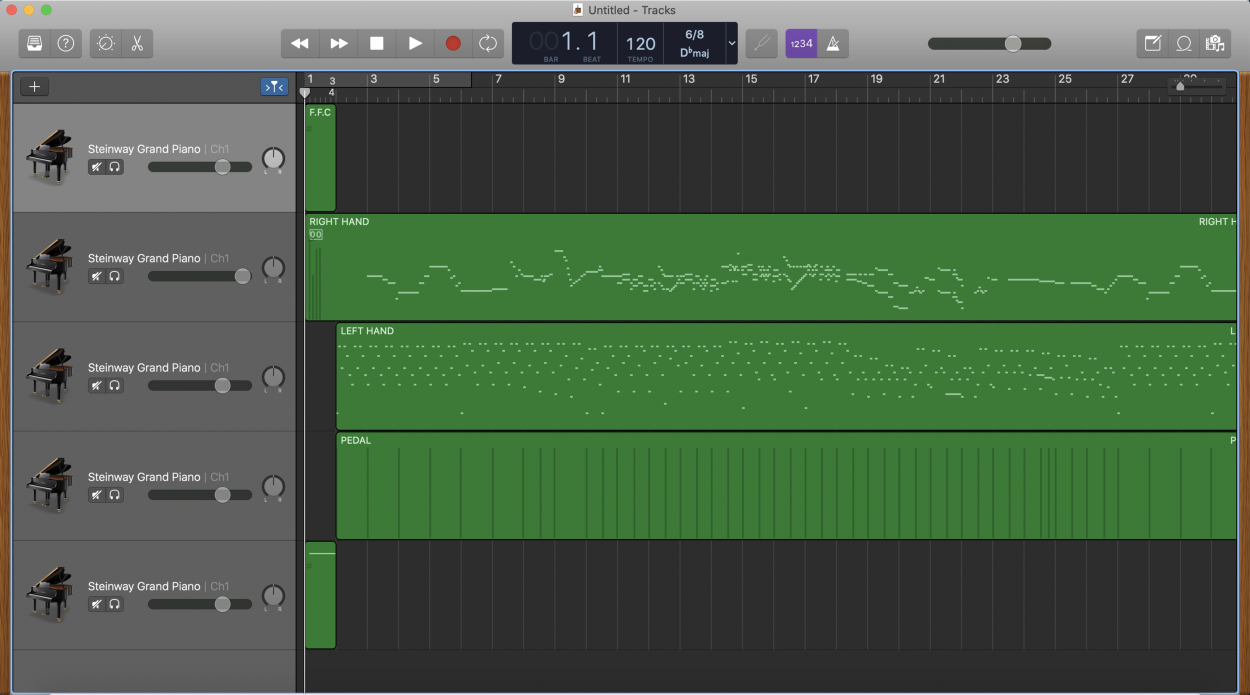

These data can be plotted for better visualisation:

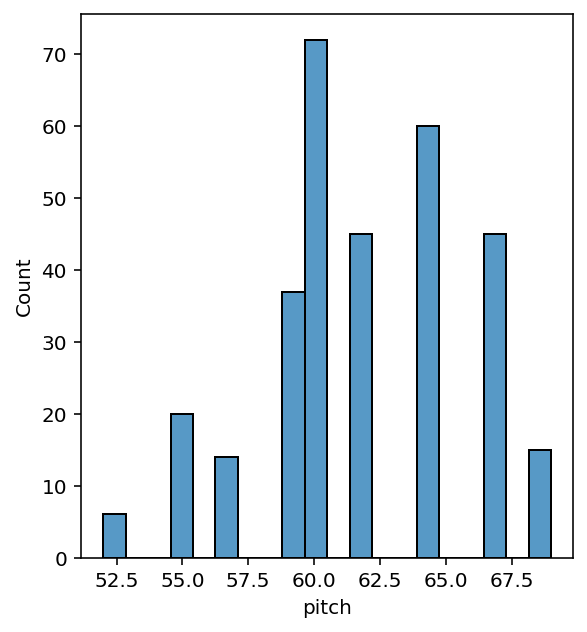

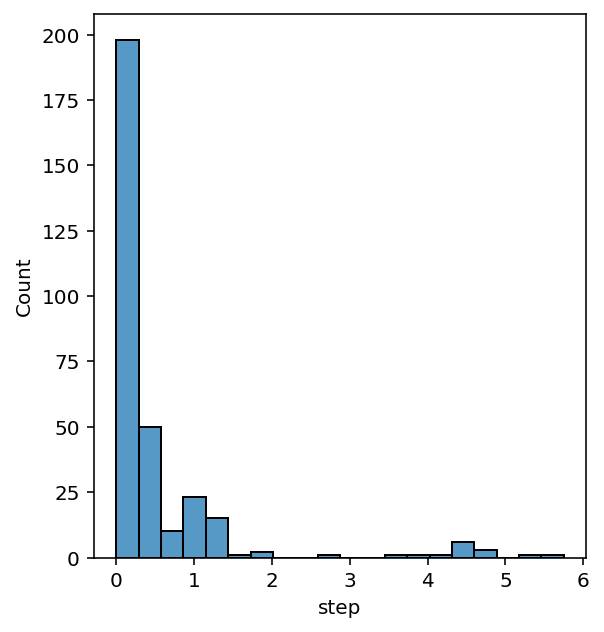

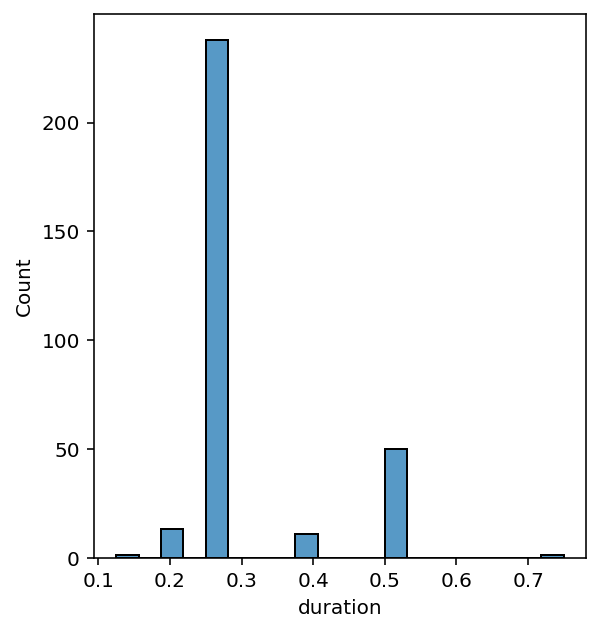

In [48]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="pitch", bins=20)

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="step", bins=20)

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="duration", bins=20)

Before training, it is essential to check if GPU is available, GPU will decrease the overall training time and can boost up the process:

In [49]:
# Check for GPU before training:
!nvidia-smi

Tue Jan 11 18:47:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    68W / 149W |   4339MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **2. Training**


Now the model will start training on the custom dataset. First, the notes from each MIDI file are extracted and stored:

In [50]:
# Extract the notes for each file in the directory:
def get_notes():
    
    notes = []
    
    # Parse each MIDI file:
    for file in glob.glob(songs):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # File has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # File has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    # Create a file to store the extracted notes:
    with open(input_notes, 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

Once the notes are extracted, the data is divided into sequences to be fed to the Model:

In [51]:
# Prepare the sequences used by the Neural Network:
def prepare_sequences(notes, n_vocab):

    sequence_length = 100

    # Extract all pitch names:
    pitchnames = sorted(set(item for item in notes))

     # Create a dictionary to map pitches to integers:
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # Create input sequences and the corresponding outputs:
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers:
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # Normalize input:
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)




Now we construct the LSTM Model:

In [75]:
# Construct the LSTM Model:
def create_network(network_input, n_vocab, load_model = False):

    # Define and construct the Layers:
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    # Load the weights for Music Generation:
    if load_model == True:
      model.load_weights('/content/weights-improvement-99-0.0442-bigger.hdf5')

    return model

We start by extracting the notes and reshaping them to feed the model. 

In [54]:
# Extract the notes:
notes = get_notes()

# Obtain the number of pitch names and reshape the data:
n_vocab = len(set(notes))
network_input, network_output = prepare_sequences(notes, n_vocab)

# Define the architecture of the Model:
model = create_network(network_input, n_vocab)
model = create_network(network_input, n_vocab, load_model = False)


Parsing /content/songs/Tones And I - Dance Monkey.mid
Parsing /content/songs/Post Malone - Circles.mid
Parsing /content/songs/Juice WRLD - Lucid Dreams.mid
Parsing /content/songs/Avicii - Without You.mid
Parsing /content/songs/Imagine Dragons - Natural.mid
Parsing /content/songs/The Weeknd ft. Daft Punk - I Feel It Coming.mid
Parsing /content/songs/The Chainsmokers ft. Halsey - Closer.mid
Parsing /content/songs/Twenty One Pilots - Heathens.mid
Parsing /content/songs/The Chainsmokers & Coldplay - Something Just Like This.mid
Parsing /content/songs/Dua Lipa - Don't Start Now.mid
Parsing /content/songs/The Chainsmokers - Paris.mid
Parsing /content/songs/James Arthur - Say You Won't Let Go.mid
Parsing /content/songs/The Weeknd - Save Your Tearsa.mid
Parsing /content/songs/Billie Eilish - Bad Guy.mid
Parsing /content/songs/TheFatRat feat. Laura Brehm - Monody.mid
Parsing /content/songs/Alan Walker - Faded.mid
Parsing /content/songs/Major Lazer - Run Up.mid
Parsing /content/songs/Kygo & Elli

We can visualise the Model to better understand its structure:

In [55]:
# Visualize the structure of the Model:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 512)          1052672   
                                                                 
 lstm_19 (LSTM)              (None, 100, 512)          2099200   
                                                                 
 lstm_20 (LSTM)              (None, 512)               2099200   
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                      

After that, The training starts. However, depending on the setup used, it can take a long time.


In [56]:
# Train the network to generate Music:
def train(model, network_input, network_output, epochs, batch_size):
    """ train the neural network """
    filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)


In [57]:
# Define the epochs and Batch size:
epochs=200
batch_size=128

# Start the training:
train(model, network_input, network_output, epochs, batch_size)

Epoch 1/200
40/40 [==============================] - 48s 1s/step - loss: 4.7323
Epoch 2/200
40/40 [==============================] - 41s 1s/step - loss: 4.2843
Epoch 3/200
40/40 [==============================] - 41s 1s/step - loss: 4.8173
Epoch 4/200
40/40 [==============================] - 41s 1s/step - loss: 4.3197
Epoch 5/200
40/40 [==============================] - 41s 1s/step - loss: 4.0255
Epoch 6/200
40/40 [==============================] - 41s 1s/step - loss: 3.8918
Epoch 7/200
40/40 [==============================] - 42s 1s/step - loss: 3.8120
Epoch 8/200
40/40 [==============================] - 43s 1s/step - loss: 3.6665
Epoch 9/200
40/40 [==============================] - 42s 1s/step - loss: 3.6268
Epoch 10/200
40/40 [==============================] - 42s 1s/step - loss: 3.5033
Epoch 11/200
40/40 [==============================] - 43s 1s/step - loss: 3.4439
Epoch 12/200
40/40 [==============================] - 43s 1s/step - loss: 3.3725
Epoch 13/200
40/40 [=================

One thing to be aware of is [Overfitting](https://www.investopedia.com/terms/o/overfitting.asp#:~:text=Overfitting%20is%20a%20modeling%20error,limited%20set%20of%20data%20points.&text=Thus%2C%20attempting%20to%20make%20the,and%20reduce%20its%20predictive%20power.), this is when the model performs well within the data used to train, but suffers when it comes to any other files that wasn't part of his training. 

It is helpful to keep track of the progess of the training and rolling back to previous saved weights in case the model's loss is low but it suffers using external data.

# **3. Generating**

After the training is complete, Music will be generated.
For the generation, the process is simple: Sequences are generated to be fed to the Pre-trained Model. The model will generate new notes that will then be converted back into a MIDI file.

We start by generating the sequences:

In [76]:
# Prepare the sequences used by the Neural Network:
def generate_sequences(notes, pitchnames, n_vocab):
    
    # Map between notes and integers and back:
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers:
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # Normalize input:
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

After that we will recreate the Pre-trained Model using the best weights recorded in training in terms of loss.

*Note*: For this we will use the same function used in the training phase *create_network* by passing an Argument stating that we want to Load the data.

Then, we will use the Model to generate notes:

In [77]:
# Generate notes from the neural network based on a sequence of notes:
def generate_notes(model, network_input, pitchnames, n_vocab):
   
    # Pick a random sequence from the input as a starting point for the prediction:
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # Generate 500 notes:
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [ ]:
# Load the notes used to train the model:
with open(input_notes, 'rb') as filepath:
    notes = pickle.load(filepath)

# Extract pitch names:
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

# Generate sequences for the Model:
network_input, normalized_input = generate_sequences(notes, pitchnames, n_vocab)

# Rebuild the model used in the training:
model = create_network(normalized_input, n_vocab, load_model= True)

After the notes are generated, we need to convert back the data to a structure we're familiar with (MIDI files) and more useful:

In [79]:
# Convert the output from the prediction to notes and create a MIDI file:
def create_midi(prediction_output):

    offset = 0
    output_notes = []

    # Create note and chord objects:
    for pattern in prediction_output:
        # Pattern is a chord:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # Pattern is a note:
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # Increase offset each iteration so that notes do not stack:
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    # Save the generated MIDI file:
    midi_stream.write('midi', fp='test_output.mid')


In [80]:
# Generate Notes:
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
# Create a new Midi File:
create_midi(prediction_output)


Now, let's listen to how generated songs sound throughout training:

In [ ]:
# Define the duration and rate:
duration = 30
rate = 16000

**1.** After 5 Epochs:

In [81]:
# Read the MIDI file:
sample_file = glob.glob(str(pathlib.Path('/content/output/output5.mid')))[0]
file = pretty_midi.PrettyMIDI(sample_file)

# Play the selected file:
waveform = file.fluidsynth(fs=rate)
waveform_short = waveform[:duration*rate]
display.Audio(waveform_short, rate=rate)

For now, it's just repeating a single note we can notice that the note was D5 and then it switched to G2. These notes are some of the most common keys, so it was probably not a coincidence.

**2.** After 50 Epochs:

In [82]:
# Read the MIDI file:
sample_file = glob.glob(str(pathlib.Path('/content/output/output50.mid')))[0]
file = pretty_midi.PrettyMIDI(sample_file)

# Play the selected file:
waveform = file.fluidsynth(fs=rate)
waveform_short = waveform[:duration*rate]
display.Audio(waveform_short, rate=rate)

After 50 epochs there's definitely a rythm and key changes but the melody is lacking. However, it's to be expected since the more repetitive part is a lot easier to learn.

**3.** After 75 Epochs:

In [83]:
# Read the MIDI file:
sample_file = glob.glob(str(pathlib.Path('/content/output/output75.mid')))[0]
file = pretty_midi.PrettyMIDI(sample_file)

# Play the selected file:
waveform = file.fluidsynth(fs=rate)
waveform_short = waveform[:duration*rate]
display.Audio(waveform_short, rate=rate)

Finally some melody is developing, it's not great yet and it's similar to the beat used in *Cold Heart* by *Dua Lipa* but at least it's moving in the right direction.

**4.** After 100 Epochs:

In [84]:
# Read the MIDI file:
sample_file = glob.glob(str(pathlib.Path('/content/output/output100.mid')))[0]
file = pretty_midi.PrettyMIDI(sample_file)

# Play the selected file:
waveform = file.fluidsynth(fs=rate)
waveform_short = waveform[:duration*rate]
display.Audio(waveform_short, rate=rate)

At this point it's starting to sound like a real song, it captures the different parts that consists a song and it sounds more like something *Imagine Dragons* would produce.

**5.** After 200 Epochs:

In [85]:
# Read the MIDI file:
sample_file = glob.glob(str(pathlib.Path('/content/output/output200.mid')))[0]
file = pretty_midi.PrettyMIDI(sample_file)

# Play the selected file:
waveform = file.fluidsynth(fs=rate)
waveform_short = waveform[:duration*rate]
display.Audio(waveform_short, rate=rate)

Probably the future Ringtone for your phone, this time the pitch is higher as it would be for the melodies used in Pop songs.

### **Limitations**

So far, the model is trained to generate Music from a Pop Songs Dataset. 

However, this is the only the beginning. With enough data and enough training, the model will be able to achieve better results utilizing other Instuments like Saxophones and Violins. This will be the subject for future research.